In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
np.set_printoptions(threshold=np.inf)
# vehicle verify --specification Superclass/superclass.vcl --network classifier:Superclass/models/model.onnx --parameter epsilon:0.0001 --dataset images:dataset/images.idx --dataset labels:dataset/labels.idx --verifier Marabou

In [2]:
from dataset import get_data
_N = 32
batch_size = 99999
mean = 0.3211
std = 0.2230
PATH,LABELS,normalise,GROUPS,GROUP_NAMES,n_classes,train_loader,test_loader = get_data(_N,batch_size)

In [3]:
_images = []
_labels = []

for image,label in train_loader:
    size = len(label)
    _images.extend(torch.Tensor.numpy(image.reshape((size,_N,_N)),force=True))
    _labels.extend(torch.Tensor.numpy(label,force=True))

In [4]:
images = np.array(_images,dtype=np.float32)
labels = np.array(_labels,dtype=np.uint8)
groups = np.array([GROUPS[i] for i in labels])

In [5]:
print(labels.shape)
print(images.shape)

(9456,)
(9456, 32, 32)


5


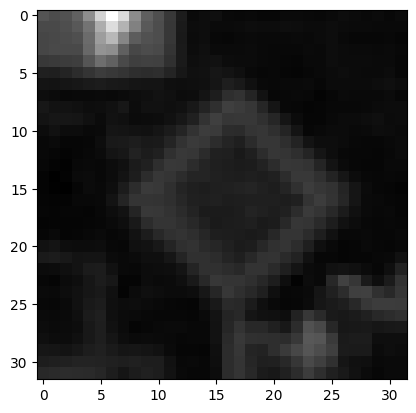

In [6]:
plt.imshow((images[1] * std) + mean,cmap="gray")
print(labels[1])

In [7]:
def get_image_bounds(img,epsilon,out):
    upperBounds = normalise(torch.ones(1,1,1,1)).item()
    lowerBounds = normalise(torch.zeros(1,1,1,1)).item()
    # epsilonBound = epsilon / std
    lower = img - epsilon # NORMALISE EPSILON PLEASE
    upper = img + epsilon

    lower = np.clip(lower,a_min=lowerBounds,a_max=upperBounds)
    upper = np.clip(upper,a_min=lowerBounds,a_max=upperBounds)

    lower = lower.reshape(_N * _N)
    upper = upper.reshape(_N * _N)

    for i,(low,up) in enumerate(zip(lower,upper)):
        out += f"(assert (<= X_{i} {up}))\n"
        out += f"(assert (>= X_{i} {low}))\n"
        out += "\n"
        
    return out


In [8]:
def get_group_constraint(current_label,out):
    # The property is proven correct if the specification is unsatisfied
    current_group = GROUPS[current_label]
    labels = range(len(GROUPS))
    out += "(assert (or\n"
    for in_group in labels:
        if GROUPS[in_group] != current_group:
            continue
        for out_group in labels:
            if GROUPS[out_group] == current_group:
                continue
            out += f"\t(and (>= Y_{out_group} Y_{in_group}))\n"
    out += "))"
    return out

In [9]:
def img_to_vnn(img,label,epsilon):
    # Start by declaring variables
    epsilon /= std
    out = f"; GTSRB Superclass Property Label: {label}\n"
    for i in range(_N * _N):
        out += f"(declare-const X_{i} Real)\n"
    for i,_ in enumerate(GROUPS):
        out += f"(declare-const Y_{i} Real)\n"

    
    out += "\n; Input Constraints\n"
    out = get_image_bounds(img,epsilon,out)
    out += "\n; Output Constraints\n"
    out = get_group_constraint(label,out)
    return out

In [10]:
# Now to write to file
# instances.csv as well ?!
# I might have to name the outputs of the network

In [12]:
def write_vnn(imgs,labels,n,epsilon): # Pull n examples per class
    frequency = np.zeros(shape=n_classes)
    save_imgs = np.zeros((n*n_classes,_N,_N),dtype=np.float64)
    save_labels = np.zeros(n*n_classes,dtype=np.uint8)
    counter = 0
    for img,label in zip(imgs,labels):
        if frequency[label] >= n:
            continue
        frequency[label] += 1
        save_imgs[counter] = img
        save_labels[counter] = label
        counter += 1
    path = "../dataset/vnn/" 
    names = []
    for i,(img,label) in enumerate(zip(save_imgs,save_labels)):
        vnn = img_to_vnn(img,label,epsilon)
        name = path + f"eps_{epsilon}_lbl_{label}_{i}.vnnlib"
        with open(name,"w") as file:
            file.write(vnn)
        names.append(name)
    # Path from complete verifier?
    with open(f"../dataset/instances_eps_{epsilon:.3f}.csv","w") as file: 
        for name in names:
            name = "../" + name + "\n"
            file.write(name)
            
write_vnn(images,labels,2,0.0196)